In [1]:
import cxsystem2.neurodynlib as nd
from brian2.units import *
import brian2 as b2
import matplotlib.pyplot as plt

b2.codegen.target = 'numpy'

# Making networks

While neurodynlib is intended for exploring neuron models, you can use it to build network simulations as well. Some knowledge of Brian2 is useful here.

## Create the neuron models

Let's first create the AdEx neuron models for our excitatory and inhibitory neurons using parameters from Naud et al. (2008) Biol Cybern (see tutorial 2 on export/import). We shall use the non-adapting neuron model (cNA) for both excitatory and inhibitory neurons.

In [2]:
naud2008_json = 'naud2008_table1.json'
exc_neuron = nd.AdexNeuron()
exc_neuron.list_neurons_in_json(naud2008_json)

['cNA',
 'cAD',
 'RS',
 'Fig_4a',
 'Fig_4b',
 'Fig_4c',
 'Fig_4d',
 'Fig_4e',
 'Fig_4f',
 'Fig_4g',
 'Figs_4h']

In [3]:
exc_neuron.read_json(naud2008_json, 'cNA')

In [4]:
inh_neuron = nd.AdexNeuron()
inh_neuron.read_json(naud2008_json, 'cNA')

Let's add some synaptic receptors (see tutorial 3 on synapses).

In [5]:
exc_receptor_model = 'SIMPLE_E'
inh_receptor_model = 'SIMPLE_I'

In [6]:
exc_neuron.set_excitatory_receptors(exc_receptor_model)
exc_neuron.set_inhibitory_receptors(inh_receptor_model)
inh_neuron.set_excitatory_receptors(exc_receptor_model)
inh_neuron.set_inhibitory_receptors(inh_receptor_model)

In [7]:
exc_neuron.set_neuron_parameters(tau_e=5.0*ms, tau_i=10*ms, Ee=0*mV, Ei=-80*mV)
inh_neuron.set_neuron_parameters(tau_e=5.0*ms, tau_i=10*ms, Ee=0*mV, Ei=-80*mV)

## Create neuron populations

We can now create excitatory and inhibitory neuron populations using the parameters defined above.

In [8]:
N_E = 10000
N_I = N_E/4
conn_prob = 0.1

In [9]:
exc_pop = exc_neuron.make_neuron_group(N_E)
inh_pop = inh_neuron.make_neuron_group(N_I)

In [10]:
exc_pop

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')

## Connecting the groups

The neuron populations are connected using Brian2's Synapses object. 
For more information on how to create synapses in Brian2, please see https://brian2.readthedocs.io/en/stable/user/synapses.html.

In [11]:
exc_weight = 0.5*nS
k = 5
inh_weight = k * exc_weight
Syn_EE = b2.Synapses(exc_pop, exc_pop, on_pre='ge_post += exc_weight')
Syn_EI = b2.Synapses(exc_pop, inh_pop, on_pre='ge_post += exc_weight')
Syn_IE = b2.Synapses(inh_pop, exc_pop, on_pre='gi_post += inh_weight')
Syn_II = b2.Synapses(inh_pop, inh_pop, on_pre='gi_post += inh_weight')

In [12]:
Syn_EE.connect(p=conn_prob)
Syn_EI.connect(p=conn_prob)
Syn_IE.connect(p=conn_prob)
Syn_II.connect(p=conn_prob)

## Background input

Let's add some background input to drive the neurons. For information on defining inputs in Brian2, see https://brian2.readthedocs.io/en/stable/user/input.html#poisson-inputs

In [13]:
N_background = int(N_E * conn_prob)
background_rate = 3*Hz
poisson_to_exc = b2.PoissonInput(exc_pop, 'ge', N_background, background_rate, weight=exc_weight)
poisson_to_inh = b2.PoissonInput(inh_pop, 'ge', N_background, background_rate, weight=exc_weight)

## Creating monitors and setting initial values

Finally, we can define what variables we want to record during the simulation. For more information on Brian2's monitors, please see https://brian2.readthedocs.io/en/stable/user/recording.html.

In [14]:
exc_spikes = b2.SpikeMonitor(exc_pop)
inh_spikes = b2.SpikeMonitor(inh_pop)
exc_rate = b2.PopulationRateMonitor(exc_pop)
inh_rate = b2.PopulationRateMonitor(inh_pop)
exc_vm = b2.StateMonitor(exc_pop, ['vm'], record=True)
inh_vm = b2.StateMonitor(inh_pop, ['vm'], record=True)

Let's randomize initial membrane voltages (rand = uniform distribution between 0 and 1). 

In [15]:
exc_pop.vm = '(EL-5*mV) + rand()*10*mV'
inh_pop.vm = '(EL-5*mV) + rand()*10*mV'

## Running the simulation

In [16]:
b2.run(3000*ms, report='text')

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]


Starting simulation at t=0. s for a duration of 3. s
1.3678000000000001 (45%) simulated in 10s, estimated 12s remaining.
2.7348000000000003 (91%) simulated in 20s, estimated 2s remaining.
3.0 (100%) simulated in 21s


## Visualizing results

Text(0.5, 0, 'Time [s]')

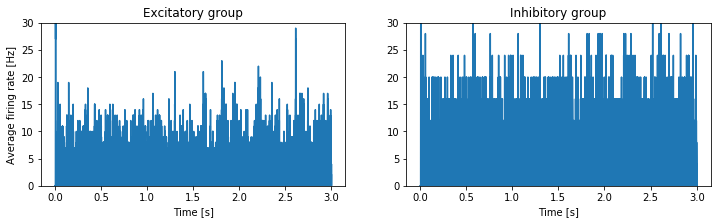

In [53]:
plt.subplots(1,2, figsize=(12,3), sharey=True)
plt.subplot(121)
plt.plot(exc_rate.t, exc_rate.rate)
plt.ylim([0,30])
plt.title('Excitatory group')
plt.xlabel('Time [s]')
plt.ylabel('Average firing rate [Hz]')

plt.subplot(122)
plt.plot(inh_rate.t, inh_rate.rate)
plt.ylim([0,30])
plt.title('Inhibitory group')
plt.xlabel('Time [s]')

Text(0.5, 0, 'Time [s]')

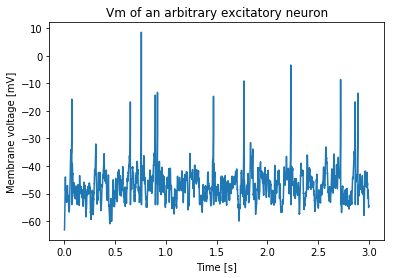

In [58]:
neuron_index = 100
plt.plot(exc_vm.t, exc_vm.vm[100]/mV)
plt.title('Vm of an arbitrary excitatory neuron')
plt.ylabel('Membrane voltage [mV]')
plt.xlabel('Time [s]')